In [445]:
import re
import time
import json
import requests
import datetime
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
from bs4 import BeautifulSoup

In [446]:
headers = {
'Host' : 'auto.ru',
'User-Agent' : 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:94.0) Gecko/20100101 Firefox/94.0',
'Accept' : 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
'Accept-Language' : 'en-US,en;q=0.5',
'Accept-Encoding' : 'gzip, deflate, br',
'Connection' : 'keep-alive',
'Cookie' : 'autoru_gdpr=1; suid=bc8be712d638a08131a6e9e0d202d740.c5b54afb905b8c06122ab3a791bcd52b; yandexuid=2760879651631376416; my=YysBAgA%3D; counter_ga_all7=2; credit_filter_promo_popup_closed=true; bltsr=1; autoru-visits-count=5; autoru_sid=a%3Ag619130a126cnq19ulaaft362m5p2vb2.ce95d73e09b71591f2b431378fbd3c26%7C1637509921806.604800.1BSyVNdQ_Jgiakk7ftwSsg.rxF87OjlP3hNehiaJwY7hz1CT9Y7Izf61mSqV5Ly0C8; autoruuid=g619130a126cnq19ulaaft362m5p2vb2.ce95d73e09b71591f2b431378fbd3c26; crookie=jpj0jVvWTMkqF2bLNEjq1Sm8BK5liRI8I2IDRbmuxJB1Z9qhACbqZpnyGeU1riNvks6acZdg/tULhikIF+VQKxi5Ddo=; deal_million_popup_page_seen=-1; credit_modal_autoshow_closed=true; _yasc=BXlfPgARlvaqwGCFNYlOD81UvI/rudyiPXKWSUFuIbFRxQ==; _csrf_token=cd33b362bade8bf97053fcccb6e8a730d67cea3890bc13dd; from_lifetime=1637870096528; from=direct; safe_deal_promo=0; yuidlt=1; cmtchd=MTYzNzg2MjAxMjI2OQ==; X-Vertis-DC=sas; los=1',
'Upgrade-Insecure-Requests' : '1',
'Sec-Fetch-Dest' : 'document',
'Sec-Fetch-Mode' : 'navigate',
'Sec-Fetch-Site' : 'none',
'Sec-Fetch-User' : '?1'
}
page_suffix = '?page='

In [447]:
perks = ['Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'bodyType', 'brand', 'color', 'complectation_dict', 'description', 'engineDisplacement', 
      'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 
      'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 
      'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'car_url']

In [448]:
def get_ad_info(url, headers, characteristics):
    ad_info = dict()   
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    for li in html.find_all('li', 'CardInfoRow'):
        var1, var2 = tuple(li.children)
        key = var1.string
        value = var2.string
        if key in perks[:7]:
            ad_info[key] = value
    
    try:
        j1 = json.loads(html.script.string)
    except:
        return
    
    try:
        j2 = json.loads(html.find('script', id="initial-state").string)
    except:
        return
        
    for k in set(perks).intersection(set(j1)):
        ad_info[k] = j1[k]

    for l in set(perks).intersection(j1['vehicleEngine']):
        try:
            ad_info[l] = j1['vehicleEngine'][l]
        except:
            pass

    for m in set(perks).intersection(j2['card']['state']):
        try:
            ad_info[m] = j2['card']['state'][m]
        except:
            pass

    try: 
        ad_info['equipment_dict'] = j2['card']['vehicle_info']['equipment'] 
    except: 
        pass
    
    try: 
        ad_info['complectation_dict'] = j2['card']['vehicle_info']['complectation'] 
    except: 
        pass
    
    try: 
        ad_info['model_info'] = j2['card']['vehicle_info']['model_info'] 
    except: 
        pass
    
    try: 
        ad_info['model_name'] = j2['card']['vehicle_info']['model_info']['name'] 
    except: 
        pass
    
    try: 
        ad_info['super_gen'] = j2['card']['vehicle_info']['super_gen'] 
    except: 
        pass
    
    try: 
        ad_info['vendor'] = j2['card']['vehicle_info']['vendor'] 
    except: 
        pass
    
    try: 
        ad_info['sell_id'] = j2['card']['saleId'] 
    except: 
        pass
    

    try: 
        ad_info['price'] = j1['offers']['price'] 
    except: 
        pass
    
    try: 
        ad_info['priceCurrency'] = j1['offers']['priceCurrency'] 
    except: 
        pass
    
    try: 
        ad_info['car_url'] = j1['offers']['url'] 
    except: 
        pass
    

    ad_info['parsing_unixtime'] = time.time()

    return ad_info

In [ ]:
time_start = datetime.datetime.now()
makes = ['', 'renault', 'toyota', 'mercedes', 'audi', 'hyundai', 'ford']
makes = ['vaz', 'chevrolet', 'mitsubishi', 'volkswagen']
for make in makes:
    df = pd.DataFrame(columns=perks)
    print(f'{make=}')
    url = 'https://auto.ru/cars/' + make + '/all/'
    rng = range(1, 100)
    for page_num in rng:
        if page_num <=1:
            page_url = url
        else:
            page_url = url + page_suffix + str(page_num)
        res = requests.get(page_url, headers=headers)
        code = BeautifulSoup(res.content, 'html.parser')
        ad_links = code.find_all("a", class_="ListingItemTitle__link")
        for l in ad_links:
            link = l['href']
            print(f'{page_num = }  __  {link = }')
            car_info = get_ad_info(link, headers, perks)
            if car_info is None:
                pass
            else:
                df = df.append(car_info, ignore_index=True,)
            time.sleep(0.5)
    time_passed = datetime.datetime.now() - time_start
    print(f'{time_passed=}')
    df.to_csv('project6' + make + '.csv')

# Работа с данными

In [449]:
df = pd.read_csv('project6.csv')
df = df.append(pd.read_csv('project6audi.csv'))
df = df.append(pd.read_csv('project6_ford_1.csv'))
df = df.append(pd.read_csv('project6_ford_3.csv'))
df = df.append(pd.read_csv('project6_ford_4.csv'))
df = df.append(pd.read_csv('project6hyundai.csv'))
df = df.append(pd.read_csv('project6mercedes.csv'))
df = df.append(pd.read_csv('project6renault.csv'))
df = df.append(pd.read_csv('project6toyota.csv'))
df = df.append(pd.read_csv('project6vaz.csv'))
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28673 entries, 0 to 28672
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 28673 non-null  int64  
 1   Unnamed: 0            28673 non-null  int64  
 2   Владельцы             21776 non-null  object 
 3   Владение              3273 non-null   object 
 4   ПТС                   21776 non-null  object 
 5   Привод                21776 non-null  object 
 6   Руль                  21776 non-null  object 
 7   Состояние             21776 non-null  object 
 8   Таможня               21776 non-null  object 
 9   bodyType              28673 non-null  object 
 10  brand                 28673 non-null  object 
 11  color                 28673 non-null  object 
 12  complectation_dict    28670 non-null  object 
 13  description           28673 non-null  object 
 14  engineDisplacement    28673 non-null  object 
 15  enginePower        

In [450]:
df['train'] = 1
df_test = pd.read_csv('test.csv')
df_test['train'] = 0
df = df.append(df_test)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63359 entries, 0 to 34685
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 28673 non-null  float64
 1   Unnamed: 0            28673 non-null  float64
 2   Владельцы             56462 non-null  object 
 3   Владение              15268 non-null  object 
 4   ПТС                   56461 non-null  object 
 5   Привод                56462 non-null  object 
 6   Руль                  56462 non-null  object 
 7   Состояние             56462 non-null  object 
 8   Таможня               56462 non-null  object 
 9   bodyType              63359 non-null  object 
 10  brand                 63359 non-null  object 
 11  color                 63359 non-null  object 
 12  complectation_dict    35088 non-null  object 
 13  description           63359 non-null  object 
 14  engineDisplacement    63359 non-null  object 
 15  enginePower        

In [451]:
df.columns

Index(['index', 'Unnamed: 0', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'bodyType', 'brand', 'color',
       'complectation_dict', 'description', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors',
       'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'car_url', 'price', 'train'],
      dtype='object')

In [452]:
df.sample(3)

,index,Unnamed: 0,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,bodyType,...,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,car_url,price,train
24243,NaN,NaN,2 владельца,1 год и 7 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,седан,...,RUB,2015,1088300454,"{""id"":""20554758"",""displacement"":1598,""engine_t...",SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,https://auto.ru/cars/used/sale/volkswagen/polo...,NaN,0
7797,NaN,NaN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,купе,...,RUB,2018,1101244569,"{""id"":""20906854"",""name"":""420"",""nameplate"":""420...",COUPE AUTOMATIC 2.0,автоматическая,EUROPEAN,https://auto.ru/cars/used/sale/bmw/4/110124456...,NaN,0
24128,2799.0,2799.0,3 или более,6 лет и 12 месяцев,Дубликат,полный,Левый,Не требует ремонта,Растаможен,минивэн,...,RUB,2007,1105175415-db056b07,"{'id': '6397522', 'name': 'II Рестайлинг', 'ru...",MINIVAN AUTOMATIC 3.5,автоматическая,JAPANESE,https://auto.ru/cars/used/sale/toyota/sienna/1...,1199000.0,1


In [453]:
#выделим признаки, с которыми будем работать
columns = ['sell_id','Владельцы','ПТС','Таможня','Привод','Руль','Состояние','mileage','bodyType','color','engineDisplacement','enginePower',
              'fuelType','vehicleTransmission','numberOfDoors','productionDate','vendor','price', 'train']
# убираем "Владение" т.к. очень мало информации, modelDate скорее всего будет коррелировать с датой выпуска-сразу удалим признак.
#'vehicleConfiguration' и 'name' удаляем т.к. у нас уже есть вся информация. Признак brand удаляем.

In [454]:
#датасет с выбранными выше признаками
df = df[columns]
df

,sell_id,Владельцы,ПТС,Таможня,Привод,Руль,Состояние,mileage,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,numberOfDoors,productionDate,vendor,price,train
0,1105117076-5afcca8a,NaN,NaN,NaN,NaN,NaN,NaN,0,купе,чёрный,2.0 LTR,197 N12,бензин,автоматическая,2,2020,EUROPEAN,5360064.0,1
1,1105828980-edee6d5a,1 владелец,Оригинал,Растаможен,полный,Левый,Не требует ремонта,62000,внедорожник 5 дв.,пурпурный,2.5 LTR,180 N12,бензин,автоматическая,5,2018,JAPANESE,2295000.0,1
2,1105892143-a25eb3c3,3 или более,Дубликат,Растаможен,передний,Левый,Не требует ремонта,185566,седан,серый,1.6 LTR,115 N12,бензин,механическая,4,2006,EUROPEAN,320000.0,1
3,1105979835-fca730a5,NaN,NaN,NaN,NaN,NaN,NaN,0,внедорожник 5 дв.,серебристый,2.0 LTR,149 N12,бензин,автоматическая,5,2021,KOREAN,1520000.0,1
4,1106014848-0b67bbc0,3 или более,Дубликат,Растаможен,передний,Правый,Не требует ремонта,300000,хэтчбек 5 дв.,розовый,1.0 LTR,70 N12,бензин,автоматическая,5,2000,JAPANESE,175000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,1101369263,3 или более,Оригинал,Растаможен,задний,Левый,Не требует ремонта,115000,седан,коричневый,1.6 LTR,136 N12,бензин,автоматическая,4,2014,EUROPEAN,NaN,0
34682,1101369581,1 владелец,Оригинал,Растаможен,полный,Левый,Не требует ремонта,98000,седан,чёрный,2.0 LTR,190 N12,дизель,автоматическая,4,2018,EUROPEAN,NaN,0
34683,1101364889,3 или более,Дубликат,Растаможен,задний,Левый,Не требует ремонта,360000,седан,серый,2.5 LTR,170 N12,бензин,автоматическая,4,1997,EUROPEAN,NaN,0
34684,1101362518,2 владельца,Оригинал,Растаможен,полный,Левый,Не требует ремонта,90500,внедорожник 5 дв.,коричневый,2.0 LTR,184 N12,дизель,автоматическая,5,2013,EUROPEAN,NaN,0


In [455]:
#уадаляем дубликаты по sell_id
df.drop_duplicates(subset=['sell_id'],inplace = True)

In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60388 entries, 0 to 34685
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sell_id              60388 non-null  object 
 1   Владельцы            54492 non-null  object 
 2   ПТС                  54491 non-null  object 
 3   Таможня              54492 non-null  object 
 4   Привод               54492 non-null  object 
 5   Руль                 54492 non-null  object 
 6   Состояние            54492 non-null  object 
 7   mileage              60388 non-null  int64  
 8   bodyType             60388 non-null  object 
 9   color                60388 non-null  object 
 10  engineDisplacement   60388 non-null  object 
 11  enginePower          60388 non-null  object 
 12  fuelType             60388 non-null  object 
 13  vehicleTransmission  60388 non-null  object 
 14  numberOfDoors        60388 non-null  int64  
 15  productionDate       60388 non-null 

<AxesSubplot:>

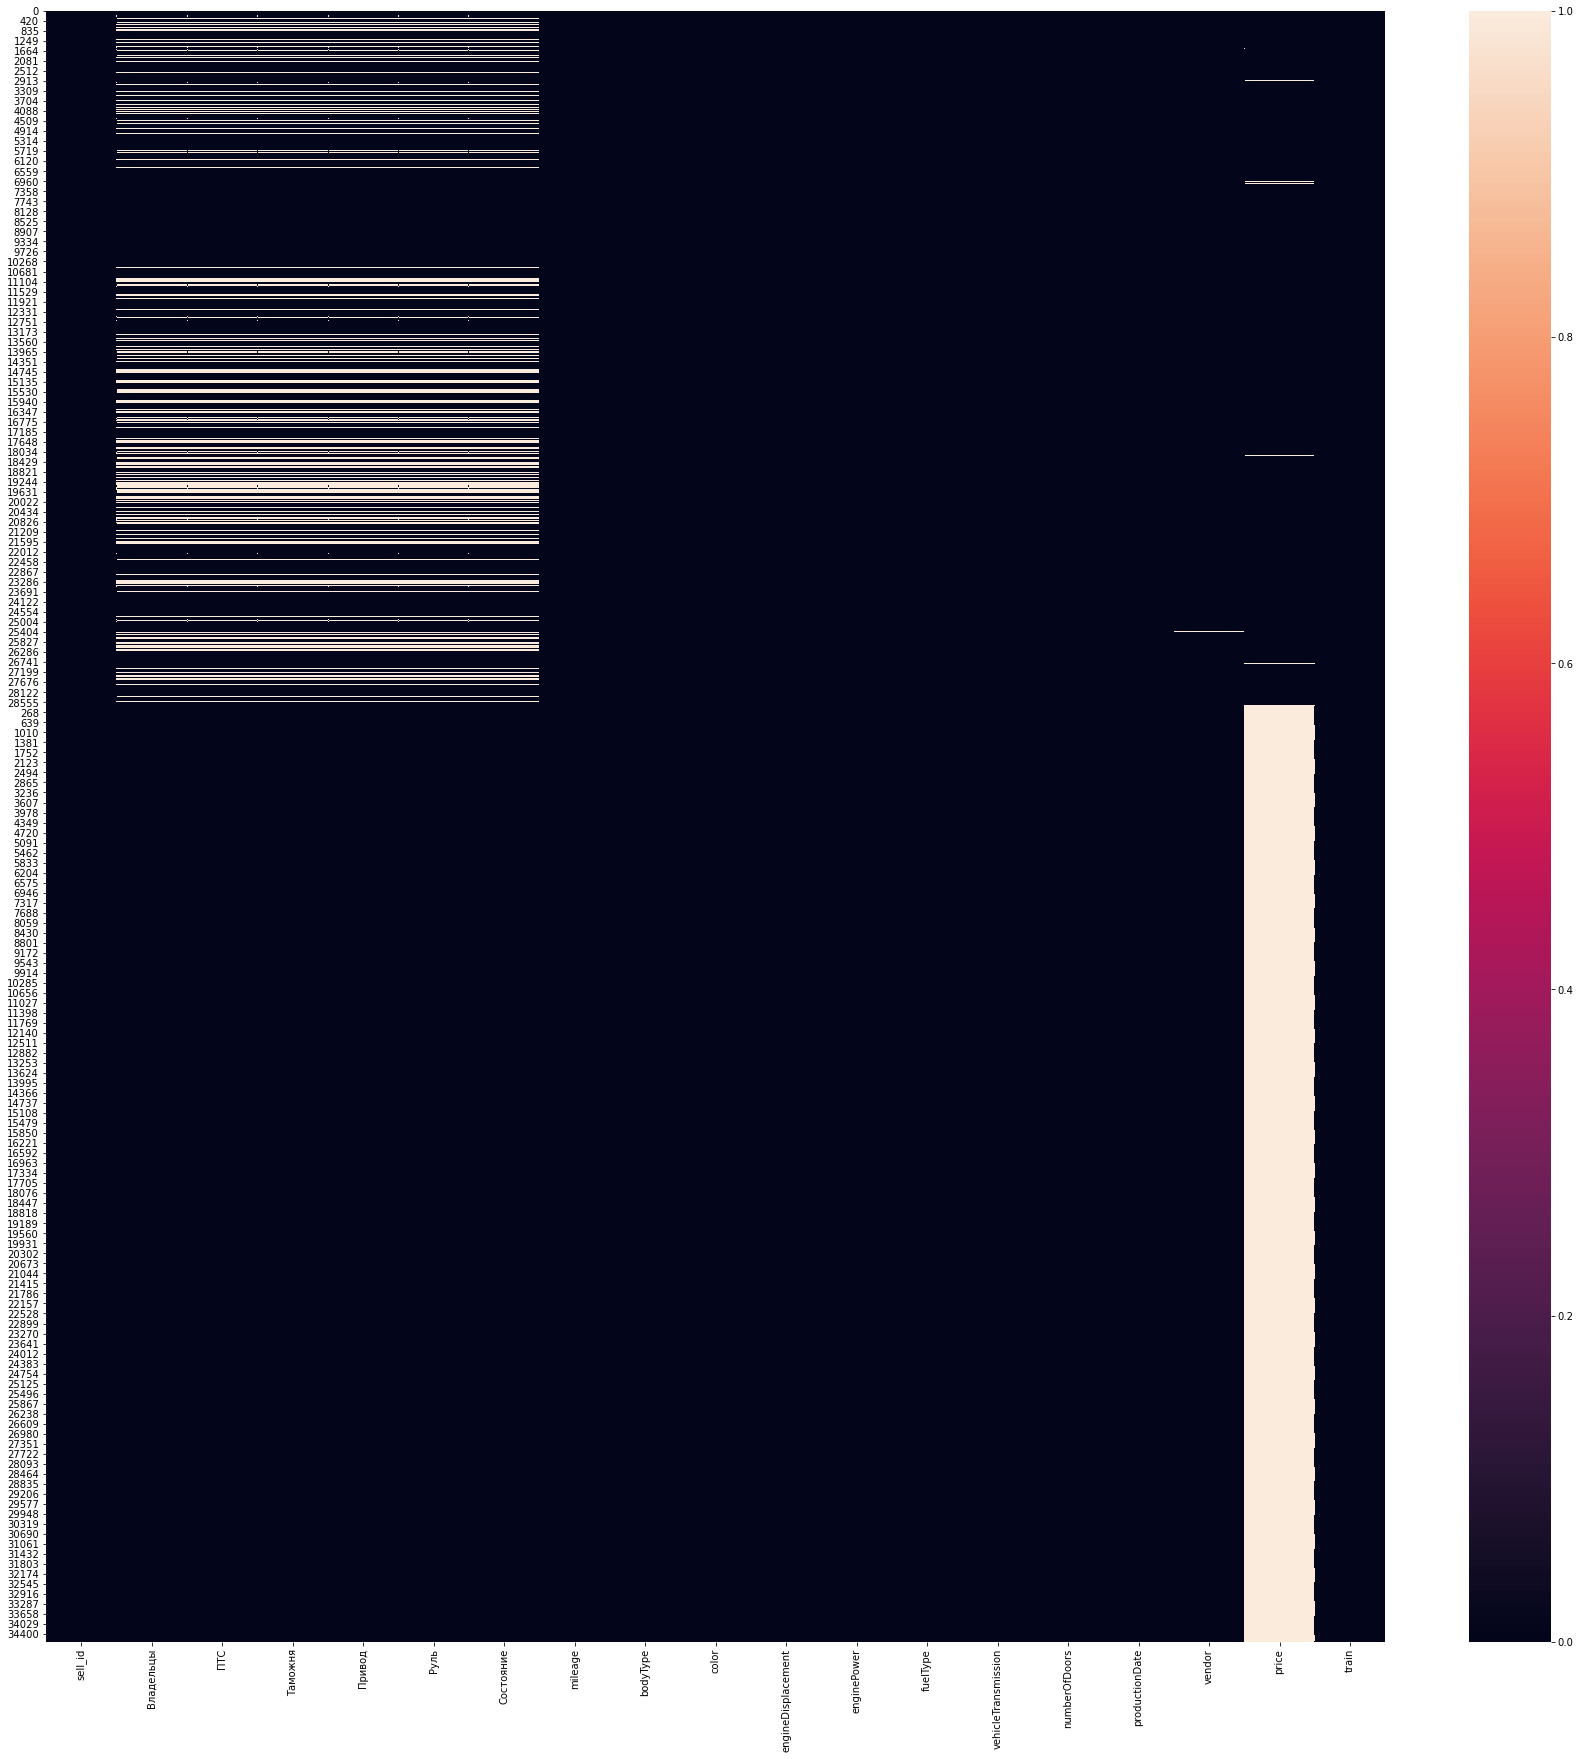

In [457]:
#Построим график пропусков
plt.subplots(figsize=(30, 30))
sns.heatmap(df.isnull())

In [458]:
#удаляем пропуски где нет цены
df_test = df.loc[df['train'] == 0, :]
df_train = df.loc[(df['train'] == 1) & (df['price'] > 0), :]

In [459]:
df = df_test.append(df_train)

In [460]:
df['Владельцы'].value_counts()

3 или более    23190
1 владелец     17129
2 владельца    13846
Name: Владельцы, dtype: int64

In [461]:
#предположим что пропуски относятся к новым автомобилям, поэтому заполним их "0"
df['Владельцы']=df['Владельцы'].fillna(0)

In [462]:
df['Владельцы'] = df['Владельцы'].apply(lambda x: 1 if str(x).startswith('1') else 2 if str(x).startswith('2') else 3 if str(x).startswith('3') else x)

In [463]:
df['ПТС'].value_counts()

Оригинал    47278
Дубликат     6886
Name: ПТС, dtype: int64

In [464]:
df['ПТС'] = df['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0)

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60061 entries, 0 to 28672
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sell_id              60061 non-null  object 
 1   Владельцы            60061 non-null  int64  
 2   ПТС                  60061 non-null  int64  
 3   Таможня              54165 non-null  object 
 4   Привод               54165 non-null  object 
 5   Руль                 54165 non-null  object 
 6   Состояние            54165 non-null  object 
 7   mileage              60061 non-null  int64  
 8   bodyType             60061 non-null  object 
 9   color                60061 non-null  object 
 10  engineDisplacement   60061 non-null  object 
 11  enginePower          60061 non-null  object 
 12  fuelType             60061 non-null  object 
 13  vehicleTransmission  60061 non-null  object 
 14  numberOfDoors        60061 non-null  int64  
 15  productionDate       60061 non-null 

In [466]:
df['Привод'].value_counts()# get_dammies

передний    26772
полный      22151
задний       5242
Name: Привод, dtype: int64

In [467]:
# применяем get_dummies и удаляем признак "Привод"
df=pd.concat([df, pd.get_dummies(df['Привод'])], axis=1)
df.drop(columns=['Привод'], inplace= True)

In [468]:
df['Руль'].value_counts()

Левый     52409
Правый     1756
Name: Руль, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


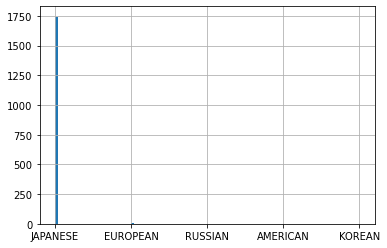

In [469]:
#Проверим корееляцию стороный руля и страны происхождения. очевидно правосторонний руль у автомобилей произвденных в Японии. 
print(df['vendor'][df['Руль'] == 'Правый'].hist(bins=100))

In [470]:
#Заполним nans исходя из предыдущего вывода.
def fill_steering(row):
    if pd.isnull(row['Руль']) and row['vendor'] == 'JAPANESE':
        return 1
    if pd.isnull(row['Руль']) and row['vendor'] != 'JAPANESE':
        return 0
    if row['Руль'] == 'Левый':
        return 0
    if row['Руль'] == 'Правый':
        return 1

In [471]:
df['Руль']=df.apply(fill_steering, axis=1)# применяем функцию

In [472]:
df['Состояние'].value_counts()

Не требует ремонта    54165
Name: Состояние, dtype: int64

In [473]:
# предположим что пропуски относятся к новым автомобилям, делаем вывод что все автомобили не требуют ремонта
# поэтому удаляем признак
df.drop(columns=['Состояние'], inplace= True)

In [474]:
df['Таможня'].value_counts()

Растаможен    54165
Name: Таможня, dtype: int64

In [475]:
# предположим что пропуски относятся к автомобилям,который растаможен делаем вывод что все автомобили растаможены
# поэтому удаляем признак
df.drop(columns=['Таможня'], inplace= True)

In [476]:
df['bodyType'].value_counts()

внедорожник 5 дв.          22167
седан                      21810
хэтчбек 5 дв.               4915
лифтбек                     2851
универсал 5 дв.             2706
минивэн                     1496
купе                        1220
компактвэн                   752
хэтчбек 3 дв.                741
пикап двойная кабина         415
внедорожник 3 дв.            308
купе-хардтоп                 205
фургон                       167
кабриолет                    123
родстер                      115
седан-хардтоп                 15
пикап полуторная кабина       11
микровэн                      11
пикап одинарная кабина         9
лимузин                        8
седан 2 дв.                    6
внедорожник открытый           5
хэтчбек 4 дв.                  2
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [477]:
df=pd.concat([df, pd.get_dummies(df['bodyType'])], axis=1) # применяем get_dummies
df.drop(columns=['bodyType'], inplace= True)

In [478]:
df['Владельцы'].value_counts()

3    23190
1    17129
2    13846
0     5896
Name: Владельцы, dtype: int64

In [479]:
df=pd.concat([df, pd.get_dummies(df['color'])], axis=1)
df.drop(columns=['color'], inplace= True)

In [480]:
df['engineDisplacement'].value_counts()

1.6 LTR    13557
2.0 LTR    12923
3.0 LTR     5499
1.8 LTR     4491
2.5 LTR     3705
1.4 LTR     2693
3.5 LTR     2421
2.4 LTR     2069
1.5 LTR     1696
1.3 LTR     1048
4.0 LTR      824
2.8 LTR      697
1.2 LTR      561
4.5 LTR      543
4.7 LTR      527
5.5 LTR      525
2.1 LTR      520
2.2 LTR      509
4.4 LTR      455
2.3 LTR      447
2.9 LTR      427
3.2 LTR      393
2.7 LTR      380
1.7 LTR      316
4.2 LTR      304
3.7 LTR      265
1.9 LTR      244
3.6 LTR      211
5.0 LTR      195
5.6 LTR      176
4.6 LTR      165
5.7 LTR      156
 LTR         134
3.1 LTR      125
1.0 LTR       95
4.8 LTR       84
2.6 LTR       78
3.8 LTR       70
6.0 LTR       67
3.3 LTR       56
0.7 LTR       56
5.4 LTR       53
3.4 LTR       52
4.1 LTR       44
6.2 LTR       43
4.3 LTR       36
5.2 LTR       23
5.9 LTR       21
0.8 LTR       18
1.1 LTR       13
5.8 LTR       12
6.3 LTR       11
5.3 LTR        8
4.9 LTR        7
6.6 LTR        6
6.8 LTR        3
6.1 LTR        3
3.9 LTR        1
Name: engineDi

In [481]:
# Преобразуем признак в численный и сразу же удаляем пропуски
df['engineDisplacement']=df['engineDisplacement'].apply(lambda x: float(str(x).replace('LTR', '')) if str(x).replace('LTR', '').strip() != '' else None)

In [482]:
df.dropna(subset=['engineDisplacement'],inplace = True)

In [483]:
df.loc[:, 'Владельцы':'price'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59927 entries, 0 to 28672
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Владельцы            59927 non-null  int64  
 1   ПТС                  59927 non-null  int64  
 2   Руль                 59927 non-null  int64  
 3   mileage              59927 non-null  int64  
 4   engineDisplacement   59927 non-null  float64
 5   enginePower          59927 non-null  object 
 6   fuelType             59927 non-null  object 
 7   vehicleTransmission  59927 non-null  object 
 8   numberOfDoors        59927 non-null  int64  
 9   productionDate       59927 non-null  int64  
 10  vendor               59924 non-null  object 
 11  price                25296 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


<AxesSubplot:>

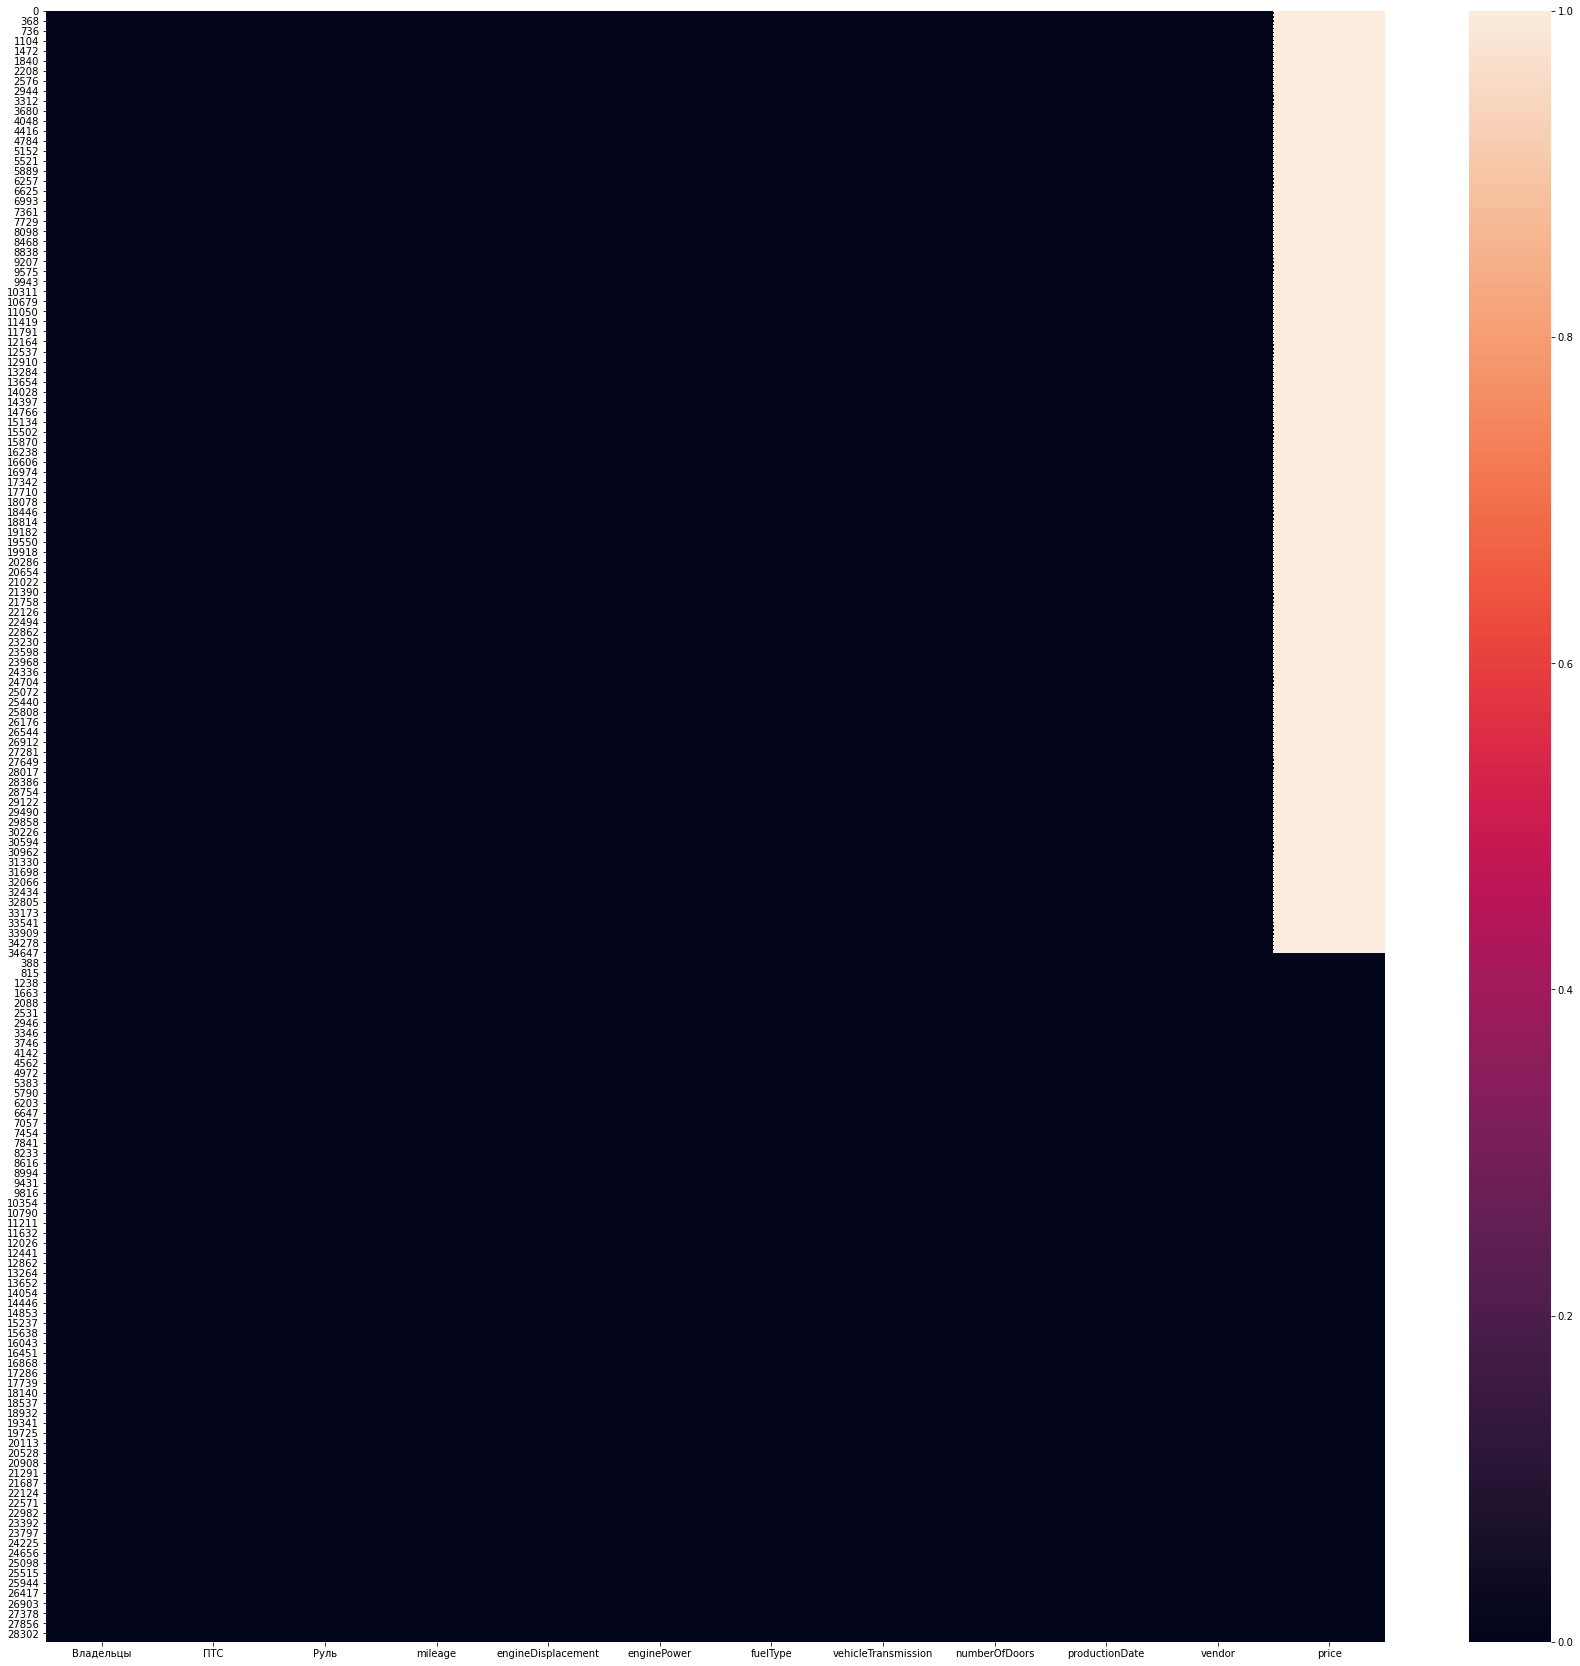

In [484]:
#Построим график пропусков
plt.subplots(figsize=(30, 30))
sns.heatmap(df.loc[:, 'Владельцы':'price'].isnull())

In [485]:
#удалим пропуски "vendor"
df.dropna(subset=['vendor'],inplace = True)

In [486]:
df['enginePower'] = df['enginePower'].apply(lambda x: x.split()[0])

In [487]:
df['enginePower']

0        105
1        110
2        152
3        110
4        152
        ... 
28668    122
28669     98
28670    106
28671     87
28672    113
Name: enginePower, Length: 59924, dtype: object

In [488]:
df['fuelType'].value_counts()

бензин    50312
дизель     9285
гибрид      311
газ          16
Name: fuelType, dtype: int64

In [489]:
df=pd.concat([df, pd.get_dummies(df['fuelType'])], axis=1)# применяем get_dummies
df.drop(columns=['fuelType'], inplace= True)

In [490]:
df['numberOfDoors'].value_counts()#оставляем без изменений

5    34054
4    23048
2     1709
3     1112
0        1
Name: numberOfDoors, dtype: int64

In [491]:
df['productionDate'].value_counts()

2021    6696
2012    4107
2013    3796
2011    3686
2008    3654
        ... 
1970       1
1961       1
1939       1
1957       1
1952       1
Name: productionDate, Length: 71, dtype: int64

In [492]:
df['vehicleTransmission'].value_counts()

автоматическая      31175
механическая        15806
роботизированная     7024
вариатор             5919
Name: vehicleTransmission, dtype: int64

In [493]:
df=pd.concat([df, pd.get_dummies(df['vehicleTransmission'])], axis=1)
df.drop(columns=['vehicleTransmission'], inplace= True)

In [495]:
df['vendor'].value_counts()

EUROPEAN    31614
JAPANESE    17622
KOREAN       3985
AMERICAN     3409
RUSSIAN      3245
CHINESE        49
Name: vendor, dtype: int64

In [496]:
df=pd.concat([df, pd.get_dummies(df['vendor'])], axis=1)
df.drop(columns=['vendor'], inplace= True)

<AxesSubplot:>

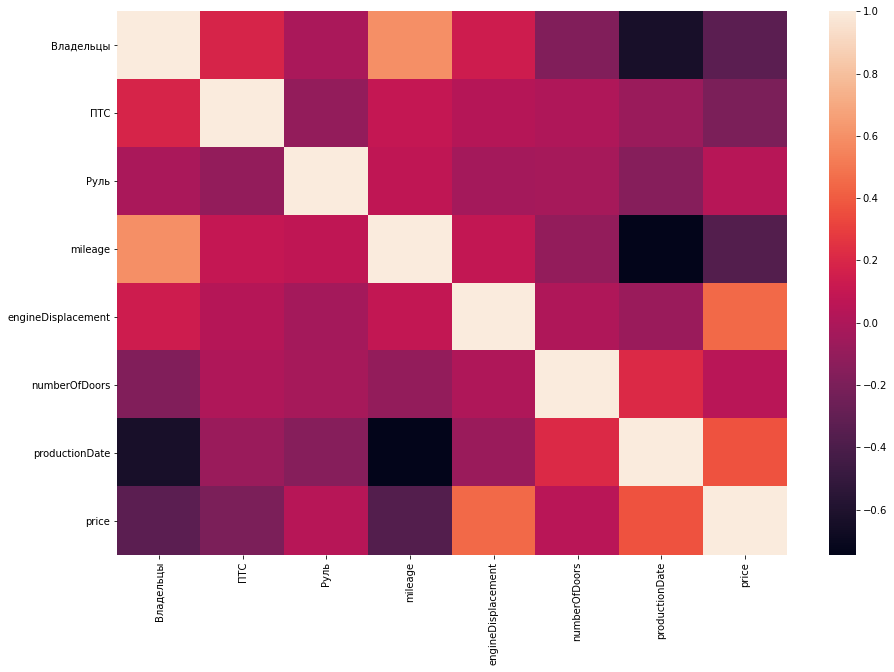

In [497]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.loc[:, 'Владельцы':'price'].corr())

In [498]:
df

,sell_id,Владельцы,ПТС,Руль,mileage,engineDisplacement,enginePower,numberOfDoors,productionDate,price,...,автоматическая,вариатор,механическая,роботизированная,AMERICAN,CHINESE,EUROPEAN,JAPANESE,KOREAN,RUSSIAN
0,1100575026,3,1,0,74000,1.2,105,5,2014,NaN,...,0,0,0,1,0,0,1,0,0,0
1,1100549428,1,1,0,60563,1.6,110,5,2017,NaN,...,0,0,1,0,0,0,1,0,0,0
2,1100658222,1,1,0,88000,1.8,152,5,2014,NaN,...,0,0,0,1,0,0,1,0,0,0
3,1100937408,1,1,0,95000,1.6,110,5,2014,NaN,...,1,0,0,0,0,0,1,0,0,0
4,1101037972,1,1,0,58536,1.8,152,5,2012,NaN,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28668,1106084272-590d68c9,2,1,0,152000,1.8,122,5,2016,554990.0,...,0,0,0,1,0,0,0,0,0,1
28669,1106067416-811209a6,3,1,0,165040,1.6,98,5,2010,309000.0,...,0,0,1,0,0,0,0,0,0,1
28670,1106085089-af6ac618,1,1,0,128135,1.6,106,4,2016,624000.0,...,0,0,0,1,0,0,0,0,0,1
28671,1106082394-0ee6a8ef,1,1,0,11801,1.6,87,4,2020,698000.0,...,0,0,1,0,0,0,0,0,0,1


In [499]:
df.drop(columns=['mileage','Владельцы'], inplace= True)# удаляем mileage и валдельцы,т.к. коррелируют с ProductionDate

In [500]:
df['Руль'].value_counts()

0    57672
1     2252
Name: Руль, dtype: int64

In [502]:
# нормализуем данные 'engineDisplacement', 'enginePower', 'productionDate'
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale=['engineDisplacement', 'enginePower', 'productionDate']
scaler.fit(df[columns_to_scale])
df[columns_to_scale]=scaler.transform(df[columns_to_scale])

In [503]:
df

,sell_id,ПТС,Руль,engineDisplacement,enginePower,numberOfDoors,productionDate,price,train,задний,...,автоматическая,вариатор,механическая,роботизированная,AMERICAN,CHINESE,EUROPEAN,JAPANESE,KOREAN,RUSSIAN
0,1100575026,1,0,0.081967,0.109170,5,0.940171,NaN,0,0,...,0,0,0,1,0,0,1,0,0,0
1,1100549428,1,0,0.147541,0.116448,5,0.965812,NaN,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1100658222,1,0,0.180328,0.177584,5,0.940171,NaN,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1100937408,1,0,0.147541,0.116448,5,0.940171,NaN,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1101037972,1,0,0.180328,0.177584,5,0.923077,NaN,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28668,1106084272-590d68c9,1,0,0.180328,0.133916,5,0.957265,554990.0,1,0,...,0,0,0,1,0,0,0,0,0,1
28669,1106067416-811209a6,1,0,0.147541,0.098981,5,0.905983,309000.0,1,0,...,0,0,1,0,0,0,0,0,0,1
28670,1106085089-af6ac618,1,0,0.147541,0.110626,4,0.957265,624000.0,1,0,...,0,0,0,1,0,0,0,0,0,1
28671,1106082394-0ee6a8ef,1,0,0.147541,0.082969,4,0.991453,698000.0,1,0,...,0,0,1,0,0,0,0,0,0,1


<AxesSubplot:>

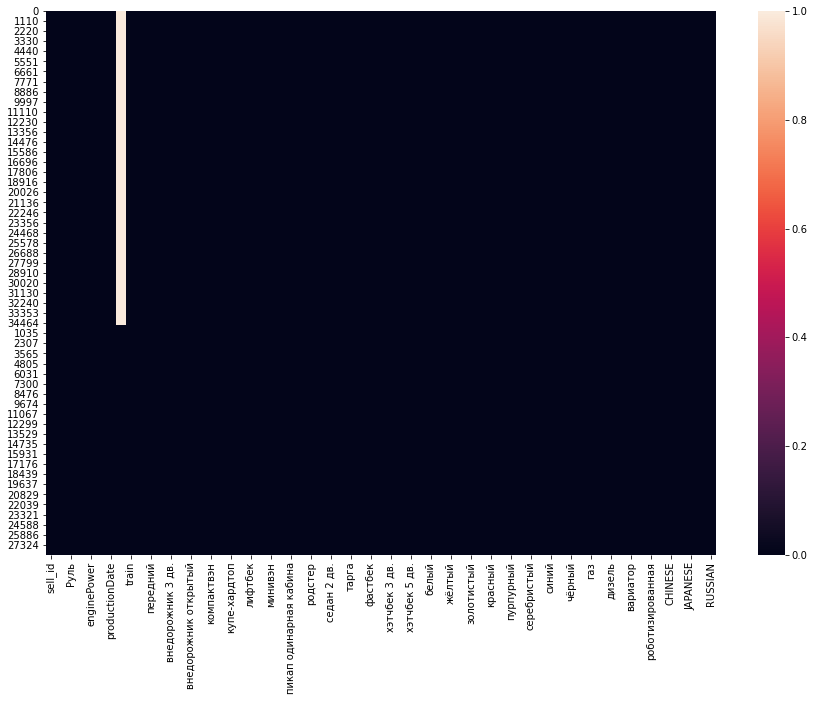

In [504]:
sns.heatmap(df.isnull())

In [505]:
# зафиксируем random_seed b test_size
RANDOM_SEED = 42
SPLIT_SIZE = 0.20


In [506]:
# pip install catboost

In [507]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np

In [508]:
df.loc[df['train']==0]

,sell_id,ПТС,Руль,engineDisplacement,enginePower,numberOfDoors,productionDate,price,train,задний,...,автоматическая,вариатор,механическая,роботизированная,AMERICAN,CHINESE,EUROPEAN,JAPANESE,KOREAN,RUSSIAN
0,1100575026,1,0,0.081967,0.109170,5,0.940171,NaN,0,0,...,0,0,0,1,0,0,1,0,0,0
1,1100549428,1,0,0.147541,0.116448,5,0.965812,NaN,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1100658222,1,0,0.180328,0.177584,5,0.940171,NaN,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1100937408,1,0,0.147541,0.116448,5,0.940171,NaN,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1101037972,1,0,0.180328,0.177584,5,0.923077,NaN,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,1101369263,1,0,0.147541,0.154294,4,0.940171,NaN,0,1,...,1,0,0,0,0,0,1,0,0,0
34682,1101369581,1,0,0.213115,0.232897,4,0.974359,NaN,0,0,...,1,0,0,0,0,0,1,0,0,0
34683,1101364889,0,0,0.295082,0.203785,4,0.794872,NaN,0,1,...,1,0,0,0,0,0,1,0,0,0
34684,1101362518,1,0,0.213115,0.224163,5,0.931624,NaN,0,0,...,1,0,0,0,0,0,1,0,0,0


In [509]:
#Выделим целевую переменную и разделим выборку на train и validate
X = df.loc[df['train'] == 1].drop(columns=['price','sell_id'])
y = df.loc[df['train'] == 1]['price']/1000000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [520]:
#обучаем модель GradientBoostingRegressor, измеряем точность
reg = GradientBoostingRegressor(random_state=RANDOM_SEED)
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
 
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 26.79%


In [521]:
# Целевые тестовые данные
XX = df.loc[df['train'] == 0].drop(columns=['price', 'sell_id'])
XX.shape

(34631, 65)

In [522]:
predict_reg = reg.predict(XX)

#### Точность модели не очень хорошая

<AxesSubplot:>

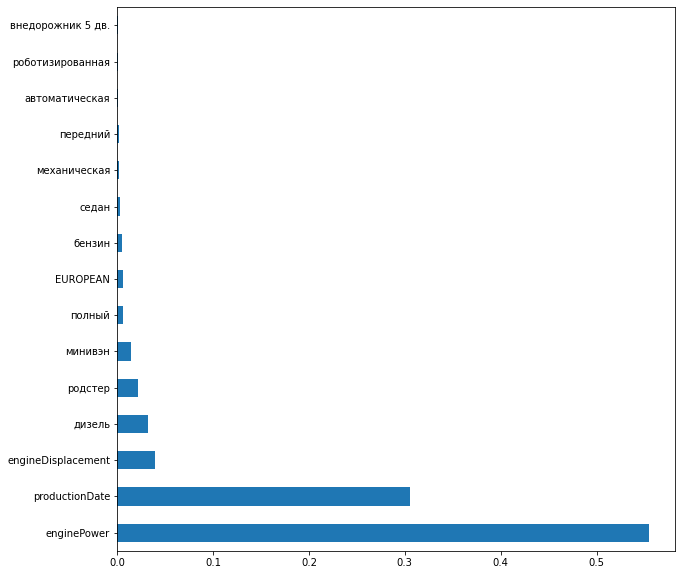

In [159]:
# Посмотрим какие признаки больше всего влияют на модель.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [70]:
# попробуем нормализовать целевую переменную.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)
y_train = np.log(y_train)
reg = GradientBoostingRegressor(random_state=RANDOM_SEED)
reg.fit(X_train, y_train)
predict = np.exp(reg.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.12%


In [523]:
y_train

8495     0.2250
8208     0.6990
23455    1.7850
8957     0.2850
21163    0.7280
          ...  
24115    3.2590
6099     4.5996
1001     0.1050
17752    0.3550
26593    0.8139
Name: price, Length: 20234, dtype: float64

In [117]:
reg.predict(X_test)

array([14.39971899, 13.54930016, 13.25586971, ..., 14.79824297,
       11.12154695, 12.54565547])

#### Точность улучшилась

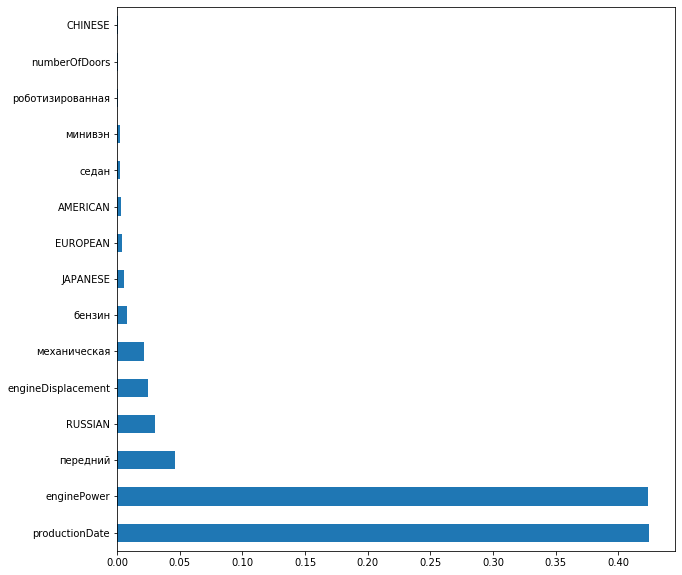

In [148]:
# Посмотрим какие признаки больше всего влияют на модель.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

#### Проверим модель на преобучение

In [164]:
y_pred_t = np.exp(reg.predict(X_train))
mape_train = mape(np.exp(y_train),y_pred_t)
print('[train] mape = {:.2f}%'.format(mape_train*100))
y_pred_v = np.exp(reg.predict(X_test))
mape_val = mape(y_test, y_pred_v)
print('[valid] mape = {:.2f}%'.format(mape_val*100))

[train] mape = 17.22%
[valid] mape = 18.12%


In [ ]:
#Видим, что точность при валидации и тестировании приблизительно равны, делаем вывод, что преобучение отсутствует

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)
model = CatBoostRegressor(iterations = 10000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         )

In [77]:
predict = (model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.57%


In [81]:
# можно добиться улучшения до 17.7 процента при домножении на 0.95 предсказанных значений
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict*0.95))*100:0.2f}%")

for i in range(20):
    print(f"{i} Точность модели по метрике MAPE: {(mape(y_test, predict*(1-i/100)))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 15.28%
0 Точность модели по метрике MAPE: 15.57%
1 Точность модели по метрике MAPE: 15.37%
2 Точность модели по метрике MAPE: 15.25%
3 Точность модели по метрике MAPE: 15.19%
4 Точность модели по метрике MAPE: 15.20%
5 Точность модели по метрике MAPE: 15.28%
6 Точность модели по метрике MAPE: 15.41%
7 Точность модели по метрике MAPE: 15.61%
8 Точность модели по метрике MAPE: 15.86%
9 Точность модели по метрике MAPE: 16.16%
10 Точность модели по метрике MAPE: 16.53%
11 Точность модели по метрике MAPE: 16.95%
12 Точность модели по метрике MAPE: 17.42%
13 Точность модели по метрике MAPE: 17.93%
14 Точность модели по метрике MAPE: 18.48%
15 Точность модели по метрике MAPE: 19.06%
16 Точность модели по метрике MAPE: 19.69%
17 Точность модели по метрике MAPE: 20.34%
18 Точность модели по метрике MAPE: 21.01%
19 Точность модели по метрике MAPE: 21.72%
